#### Beschreibung:
Notebook, das als Präsentationsgrundlage verwendet werden kann. Es zeigt die verschiedenen Ansätze, die zum Vergleich der Signale verwendet werden sowie die Auswirkungen auf konkrete Datensätze.

#### Workflow:
Echtdaten werden über die Notebooks data_force_sensor/clean_data bzw. data_machine/clean_data aus der MongoDB (Datenbank) ausgelesen. Zum Vergleich dieser Notebooks wird die Normalisierte Kreuzkorrelation aus data_compare/Normalized_Cross_Correlation verwendet.

In [1]:
%run ../Setup.ipynb
%matplotlib inline

from isac import configuration as cfg
from data_compare import normalized_cross_correlation as compare_normalized_cross_correlation
from data_force_sensor import clean_data as data_force_data
from data_machine import clean_data as data_trace_data
import matplotlib.pyplot as plt
import pandas as pd
import datetime

In [2]:
print("")
print("#######################################")
print("### Versuch: " + cfg.project_database)
print("#######################################")
print("")


#######################################
### Versuch: ISAC_KONV_1_2
#######################################



#### Datensatz einlesen

In [3]:
from importlib import reload
# reload(data_force_data)
# reload(data_trace_data)
data_force_data = reload(sys.modules["data_force_sensor.clean_data"])
data_trace_data = reload(sys.modules["data_machine.clean_data"])

In [4]:
df_trace_data = data_trace_data.df.copy()
df_force_data = data_force_data.df.copy()

def normalize_by_min_max(series):
    series_min = series.min()
    series_max = series.max()
    return (series - series_min) / (series_max - series_min)

def normalize_by_mean(series):
    series_std = series.std()
    series_mean = series.mean()
    return (series - series_mean) / (series_std)

normalize_data = False
if normalize_data:
    df_trace_data["Virtuelle Kraft"] = normalize_by_min_max(df_trace_data["Virtuelle Kraft"])
    df_force_data["fsum"] = normalize_by_min_max(df_force_data["fsum"])
    
    # df_trace_data["Virtuelle Kraft"] = normalize_by_mean(df_trace_data["Virtuelle Kraft"])
    # df_force_data["fsum"] = normalize_by_mean(df_force_data["fsum"])


In [5]:
df_trace_data_label = 'Virtuelle Kraft'
df_force_data_label = "fsum"

result = {}
result["name"] = cfg.project_database
result["trace"] = {}
result["trace"]["datapoints"] = len(df_trace_data)
result["trace"]["duration"] = df_trace_data[-1:]["time"]
result["force"] = {}
result["force"]["datapoints"] = len(df_force_data)
result["force"]["duration"] = df_force_data[-1:]["time"]

In [6]:
plt.rcParams['figure.dpi'] = 300

# Virtuelle Kraftsensorik

## Hintergrund

Ziel war es, durch eine Berechnung der Trace-Daten einer Fräsmaschine – über mehrere Versuche hinweg –  aufzuzeigen, dass die auftretenden Kräfte virtuell abbildbar sind. Hintergrund ist der Versuch, aufwändige und teure Messsensorik durch eigens gemessener Daten der Verarbeitungmaschinen einzusparen. Die Untersuchung stellt eine erste Proof-Off-Konzept-Studie dar.

## Aufbau 

Über vier verschiedene Modelle des Fräsens (HMILL, KONV, SCAM, SIM) wurden jeweils sechs Versuche gefahren, bei denen die Trace-Daten der Fräsmaschine, wie auch die auftretennden Kräfte, durch entsprechende Messsensorik, aufgezeichnet wurden. Mit 24 Datensätzen konnten nun Vergleichsrechnungen angestellt werden. 
In einem ersten Schritt wurden die entsprechenden Trace-Datensätze zur virtuellen Kraftsensorik identifiziert und verrechnet. Durch eine Evaluation der besten Analysealgorithmen, konnte ein effizienter Aufbau zum Vergleich der virtuellen Daten mit den gemessenen Kraftdaten erarbeitet werden.

Da beim Erheben der verschiedenen Datensätze die Signale unterschiedlich lang aufgenommen wurden ist es notwendig, das Signal auf das relevante Signal zu beschränken, um für den schlussendlich erwünschten Vergleich eine Aussage treffen zu können.

Durch die Konfiguration eines bestimmten Fräsprojekts werden im ersten Schritt die virtuellen Kraftdaten berechnet, anschließend mittels Schwellwerterkennung auf den relevanten Teil gekürzt. Diese Verkürzung findet auch bei den gemessenen Kraftdaten statt. Diese beiden neuen Datensätze dienen als Ursprung für die Vergleichsberechnung, mittels der normalisierten Cross-Korrelation werden die beiden Datensätze übereinander gelegt. In einem abschließenden Schritt wird nun verglichen, wie ähnlich die beiden Kraft-Ergebnisse sind.

## Zu analysierende Datensätze

Es gibt hier zwei verschiedene Datensätze.
Entstanden sind sie einmal durch die "teure Messsensorik" (Force Data) und das andere Mal mit Hilfe von einfacheren bzw. günstigeren Hilfsmitteln und virtuell berechneten Kennzahlen (Trace Data).

#### Basic Math For Calculation

__P = ω * M__

P = Leistung  
ω = Omega, Kreifrequenz (Rad/Sec.)  
M = Drehmoment = r * F // Kann zur Berechnung herangezogen werden
r = Radius des Fräskopfes = 5 mm = 0,005 m  
F = Kraft, die gesuchte Größe

__⇒ F = M / r__ 

Man kann den Datensätzen "auf den ersten Blick" entnehmen, dass sie sich ähnlich sehen, aber nicht komplett gleich sind. Das ist wahrscheinlich auf die genaueren Sensordaten direkt aus der Maschine zurückzuführen.
Ebenso kann man aber entnehmen, dass sie sich ähnlich genug zu sein scheinen, um zu erkennen, wann bestimmte Ereignisse eintreten und wann nicht.
Standartmäßig lagen in den Messdaten Verschiebungen vor, die zuerst einmal korrigiert werden mussten. Außerdem wurden die Signale auf den relevanten Teil der Messung (Anstieg / Abstieg) selektiert.

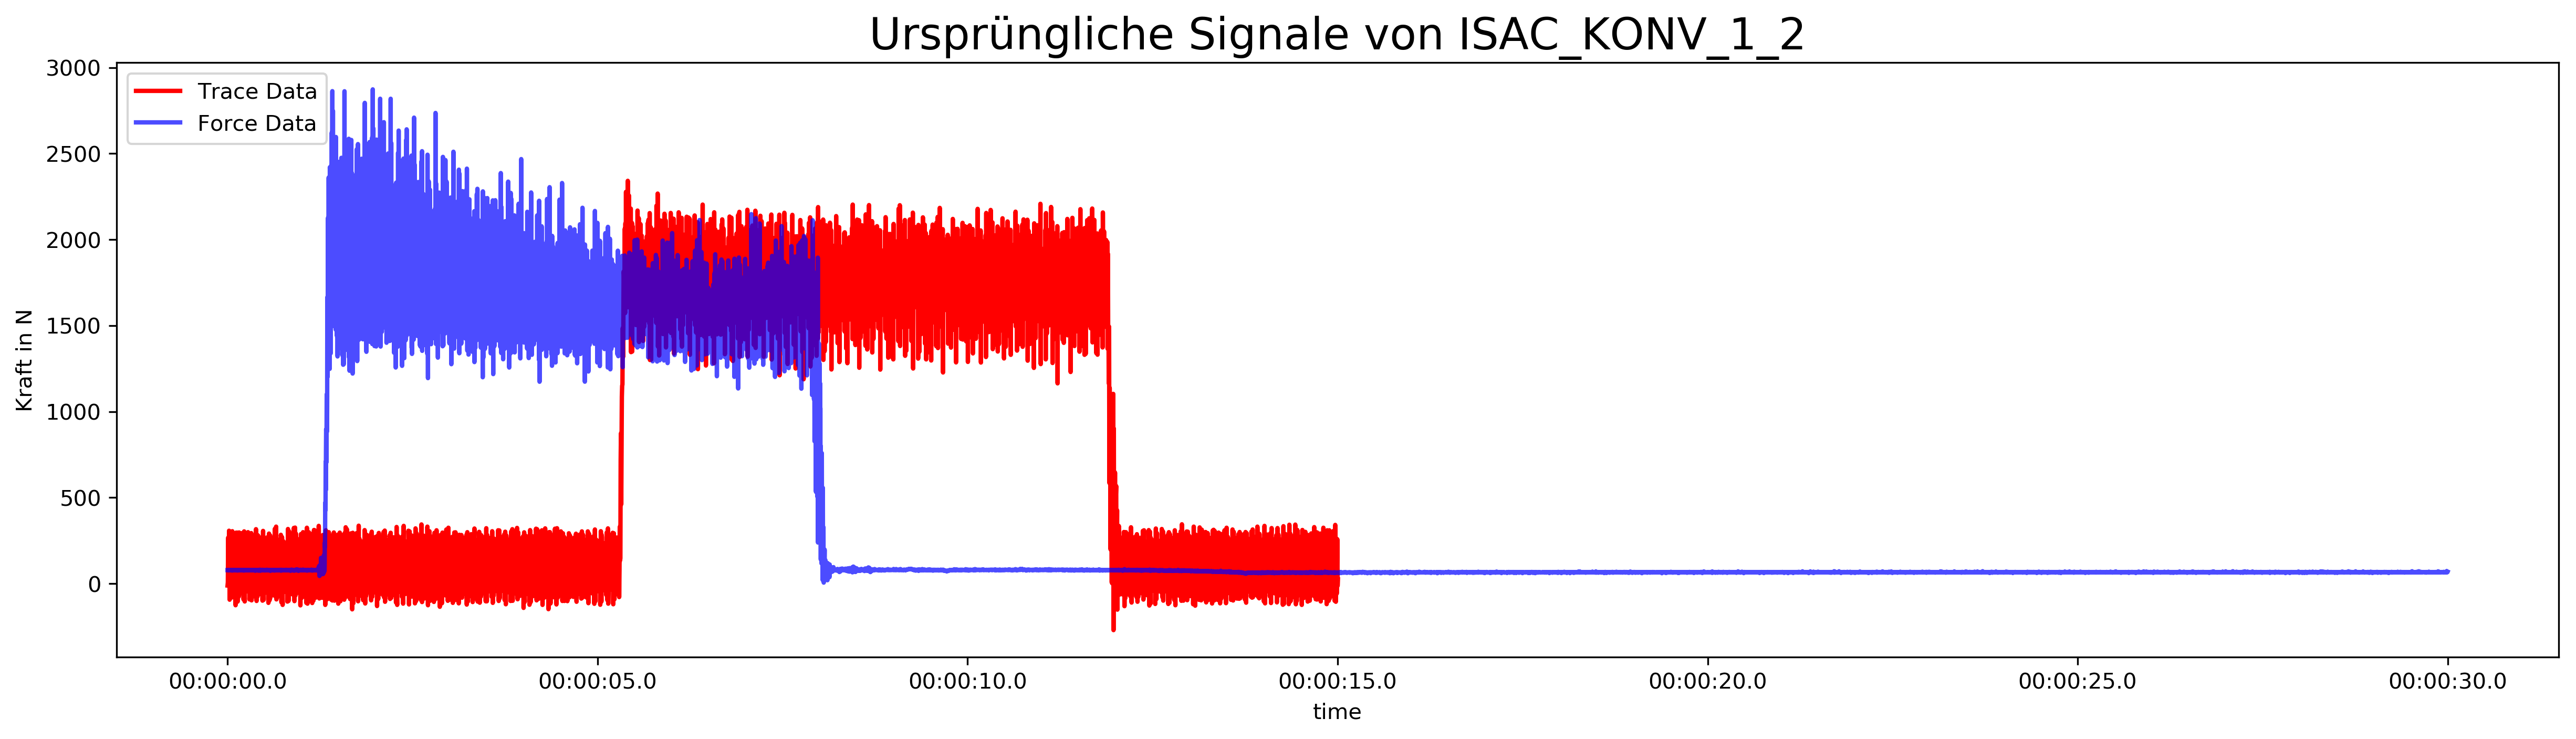

In [7]:
fig, axes = plt.subplots(figsize=(20,5))

df_trace_data.plot(color='red', ax=axes, x='time', y=df_trace_data_label, linewidth=2.0, label="Trace Data");
df_force_data.plot(color='blue', ax=axes, x='time', y=df_force_data_label, linewidth=2.0, label="Force Data", alpha=0.7);

title = "Ursprüngliche Signale von " + cfg.project_database;

axes.set_title(title, fontdict = {'fontsize': 20})
axes.set_ylabel("Kraft in N");
axes.legend(loc='upper left')

plt.show()

## Relevantes Signal selektieren
Um nur die relevanten Signale miteinander zu vergleichen betrachten wir zuerst, welcher Teil des Signals relevant für unseren Vergleich ist. Relevant ist der Übergang vom Low- zum High-Signal und wieder zurück. Dieses Subsignal wollen wir später dann mit dem jeweiligen anderen vergleichen.

Um das relevante Signal selektieren zu können berechnen wir uns den Mittelwert aus dem Höchst- und Tiefstwerten des Signals. Sobald ein Wert diesen Schwellwert das erste Mal überschreitet, zählt das Signal als relevant und bleibt relevant, bis es das letzte Mal diesen Schwellwert überschreitet. Danach ist das Signal für den Vergleich nicht mehr relevant.
Um das Signalrauschen zu reduzieren verwenden wir einen gleitenden Durchschnitt.

In [8]:
#
# Selektiert das relevante Signal und gibt es zurück
#
# data: Datensatz, aus dem das relevante Signal selektiert werden soll
# kraft_attribut: Kraft-Attribut, das zum Auslesen der Daten verwendet werden soll
# 
def get_relevant_signal(data, kraft_attribut, start_signal_at_0 = True):
    # Gleitender Durchschnitt (Um zu starkes Rauschen des Signals abzufangen)
    anzahlElementeImZeitfenster = 50
    anzahlElementeImZeitfensterHaelfte = int(round(anzahlElementeImZeitfenster / 2))
    
    # Bildet den gleitenden Durchschnitt über einen definierten Timeframe (rolling + mean) und
    # zentriert (shift) diesen auf dem vorherigen Start-Zeitpunkt
    data_gd = data[['time', kraft_attribut]].copy();
    data_gd[kraft_attribut] = data_gd[kraft_attribut] \
                                .rolling(window=anzahlElementeImZeitfenster) \
                                .mean() \
                                .shift(-anzahlElementeImZeitfensterHaelfte);
    
    # Schwellwert
    # Mittelwert des Hoch- und Tiefpunktes des Gleitendes Durchschnittes
    schwellwert = (data_gd[kraft_attribut].max() + data_gd[kraft_attribut].min()) / 2
    
    # Anfangs- und Endpunkt berrechnen
    # Der erste Wert über dem Schwellwert
    erstes_signal = data_gd[data_gd[kraft_attribut] > schwellwert].index[0]
    # Der letzte Wert über dem Schwellwert
    letztes_signal = data_gd[data_gd[kraft_attribut] > schwellwert].index[-1]
    
    # Offset Beginn und Ende hinzufügen, um ein visuell besseres Ergebnis zu erhalten
    # Ist für die Berechnung des Vergleichs an sich nicht umbedingt notwendig
    erstes_signal -= 100
    letztes_signal += 100
    
    # Offset bei Randfällen korrigieren
    if erstes_signal < 0:
        erstes_signal = 0    
    if letztes_signal > len(data):
        letztes_signal = len(data)
    
    # Signal selektieren
    relevantes_signal = data[erstes_signal:letztes_signal]
    relevantes_signal = relevantes_signal.reset_index(drop=True)
    
    # Zeitnormalisierung / Signal soll bei 0 starten
    time_offset = relevantes_signal["time"][0]
    if start_signal_at_0:
        relevantes_signal["time"] = relevantes_signal["time"].apply(lambda x:
                                        x - time_offset)

    # Ab wann das relevante Signal eigentlich erst beginnt.
    # Davon ausgehend wurde das relevante Signal selektiert
    print("Verschiebung um: " + str(time_offset))
    return relevantes_signal

In [9]:
# Berechnen der beiden relevanten Signale
print ("Force Data")
subset_signal_force_data = get_relevant_signal(df_force_data.copy(), df_force_data_label)
subset_signal_force_data_without_offset_shift = get_relevant_signal(df_force_data.copy(), df_force_data_label, False)

print ("\nTrace Data")
subset_signal_trace_data = get_relevant_signal(df_trace_data.copy(), df_trace_data_label)
subset_signal_trace_data_without_offset_shift = get_relevant_signal(df_trace_data.copy(), df_trace_data_label, False)

result["force"]["duration_relevant_signal"] = subset_signal_force_data[-1:]["time"]
result["trace"]["duration_relevant_signal"] = subset_signal_trace_data[-1:]["time"]

Force Data
Verschiebung um: 0 days 00:00:01.138000
Verschiebung um: 0 days 00:00:01.138000

Trace Data
Verschiebung um: 0 days 00:00:05.130000
Verschiebung um: 0 days 00:00:05.130000


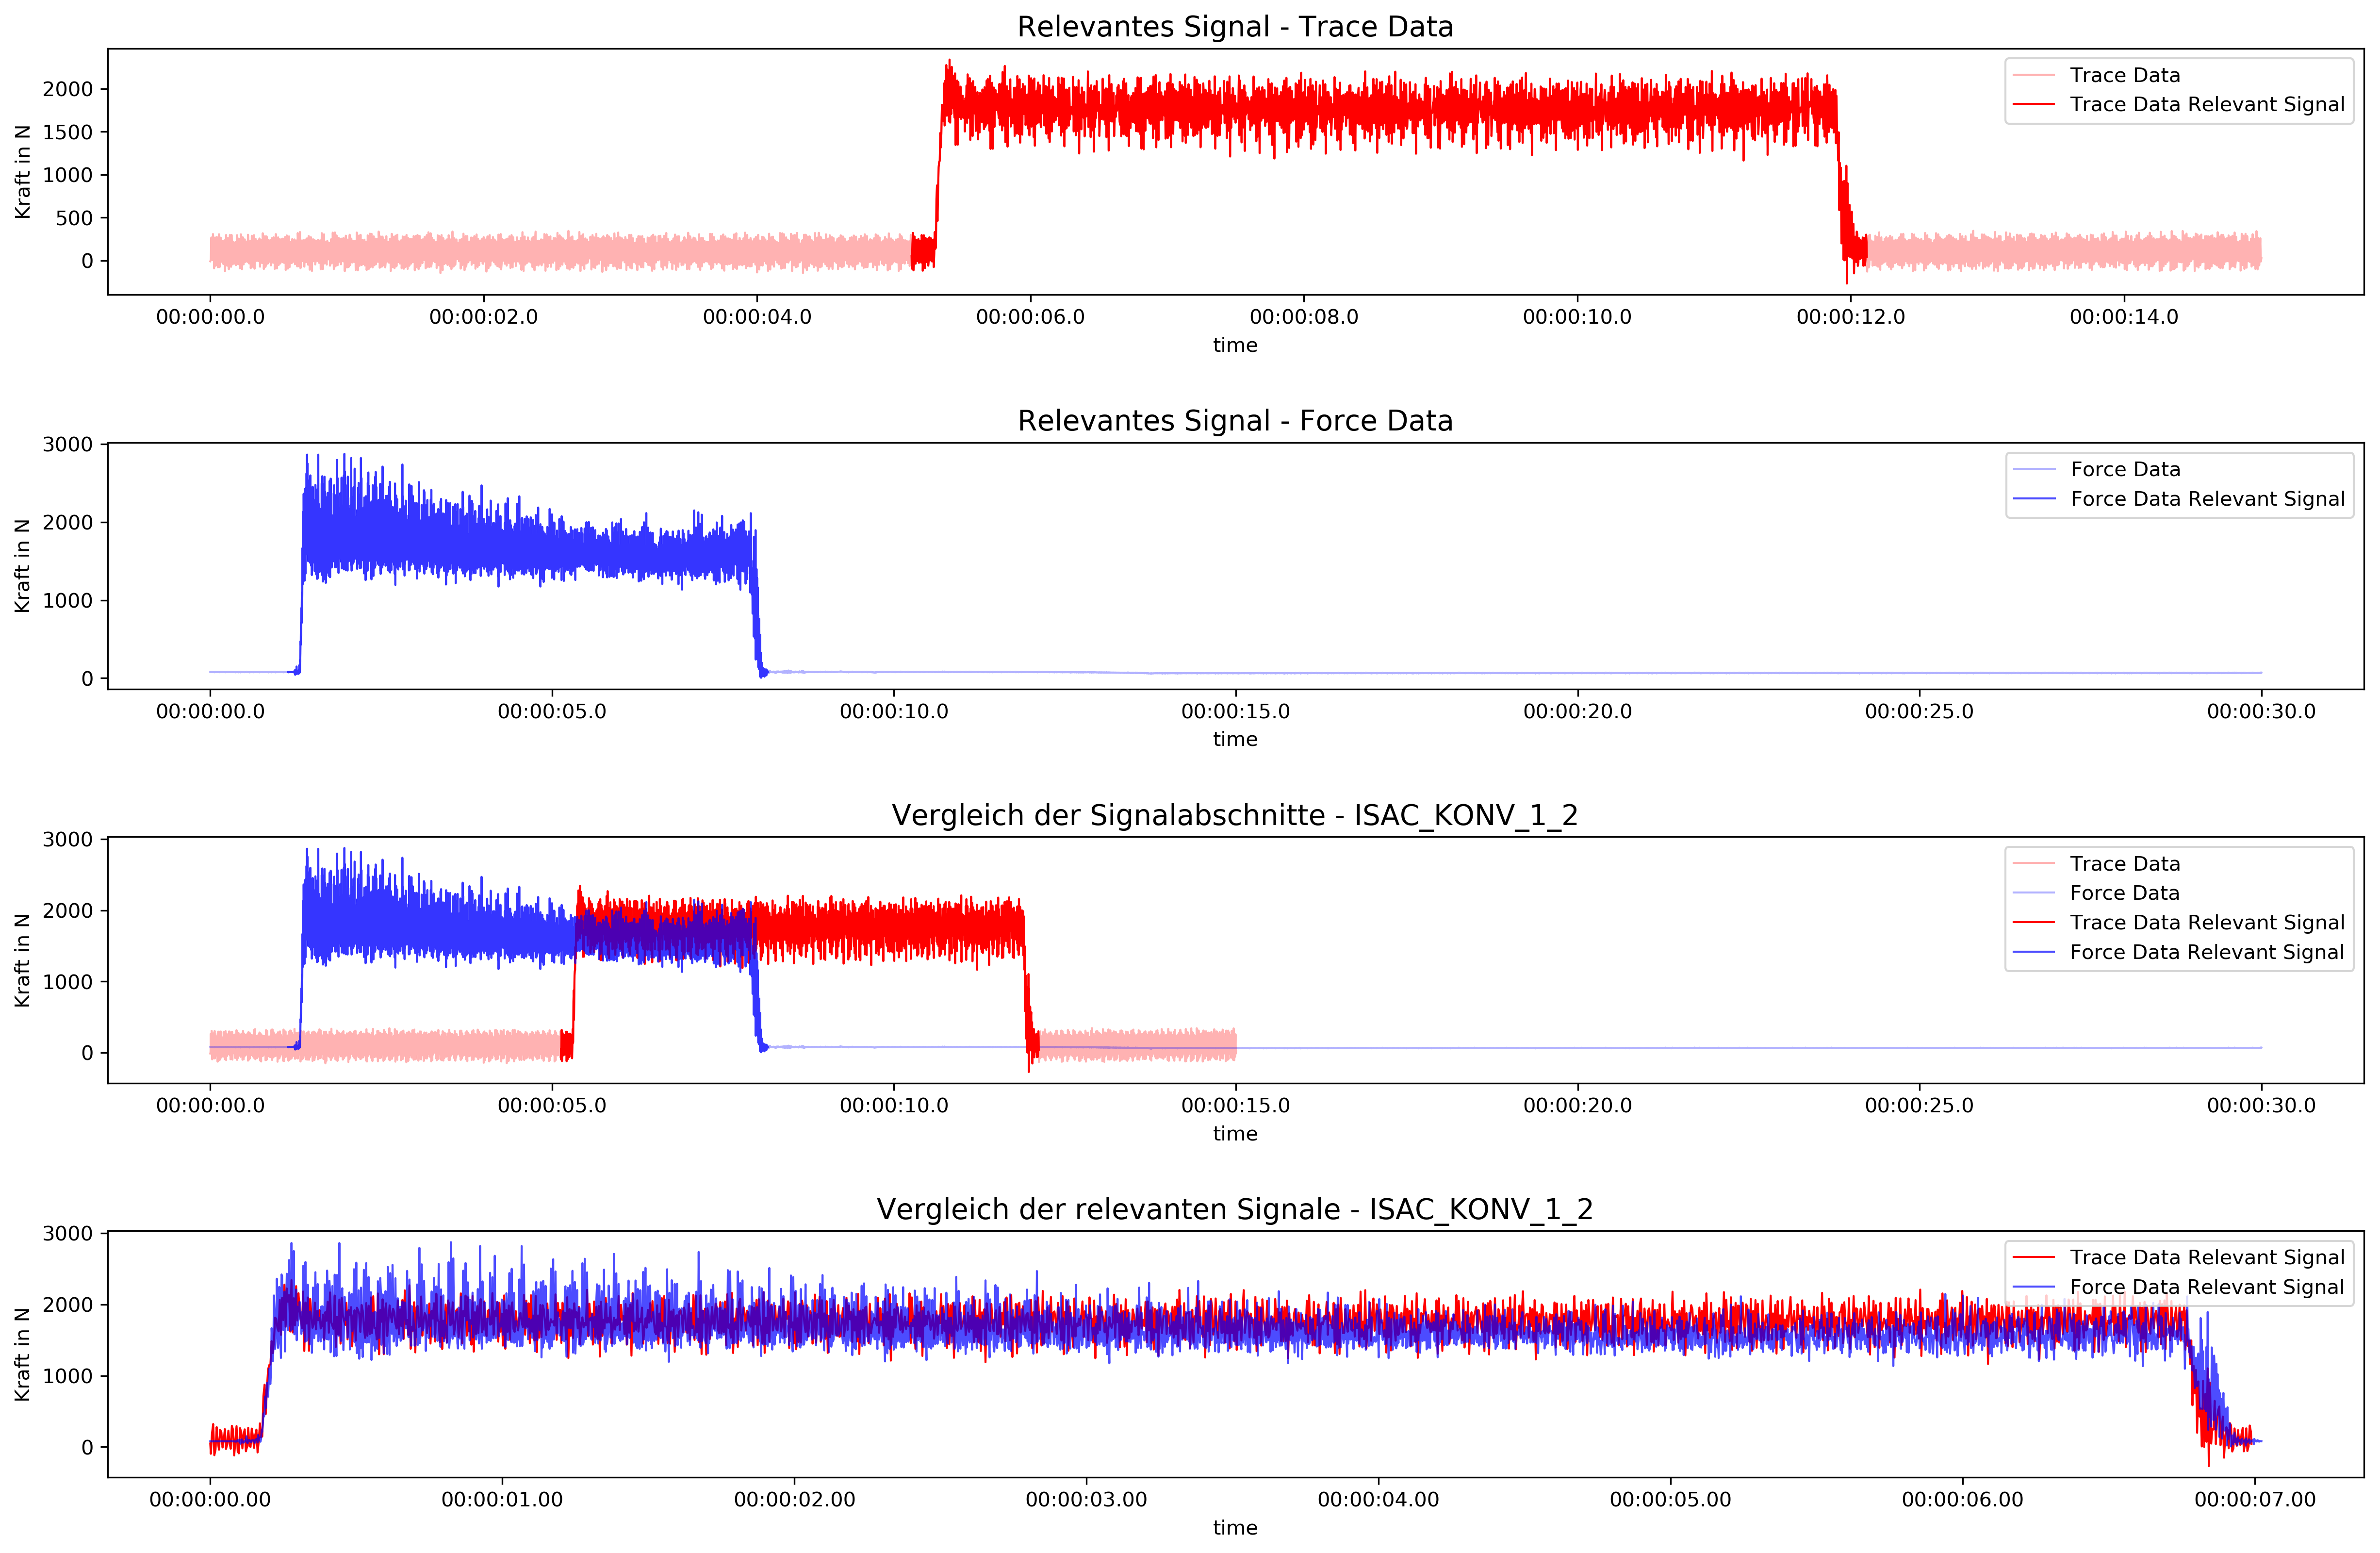

In [10]:
fig, axes = plt.subplots(nrows=4, figsize=(20,13))
fig.subplots_adjust(hspace=0.6)

ax_trace_data = axes[0]
df_trace_data.plot(color='red', ax=ax_trace_data, x='time', y=df_trace_data_label, linewidth=1.0, label="Trace Data", alpha = 0.3)
subset_signal_trace_data_without_offset_shift.plot(color='red', ax=ax_trace_data, x='time', y=df_trace_data_label, linewidth=1.0, label="Trace Data Relevant Signal")
ax_trace_data.set_title("Relevantes Signal - Trace Data", fontdict = {'fontsize': 14})
ax_trace_data.set_ylabel("Kraft in N")
ax_trace_data.legend(loc='upper right')

ax_force_data = axes[1]
df_force_data.plot(color='blue', ax=ax_force_data, x='time', y=df_force_data_label, linewidth=1.0, label="Force Data", alpha=0.3);
subset_signal_force_data_without_offset_shift.plot(color='blue', ax=ax_force_data, x='time', y=df_force_data_label, linewidth=1.0, label="Force Data Relevant Signal", alpha=0.7)
ax_force_data.set_title("Relevantes Signal - Force Data", fontdict = {'fontsize': 14})
ax_force_data.set_ylabel("Kraft in N")
ax_force_data.legend(loc='upper right')

ax_compare_both = axes[2]
df_trace_data.plot(color='red', ax=ax_compare_both, x='time', y=df_trace_data_label, linewidth=1.0, label="Trace Data", alpha = 0.3)
df_force_data.plot(color='blue', ax=ax_compare_both, x='time', y=df_force_data_label, linewidth=1.0, label="Force Data", alpha=0.3);
subset_signal_trace_data_without_offset_shift.plot(color='red', ax=ax_compare_both, x='time', y=df_trace_data_label, linewidth=1.0, label="Trace Data Relevant Signal")
subset_signal_force_data_without_offset_shift.plot(color='blue', ax=ax_compare_both, x='time', y=df_force_data_label, linewidth=1.0, label="Force Data Relevant Signal", alpha=0.7)
ax_compare_both.set_title("Vergleich der Signalabschnitte - " + cfg.project_database, fontdict = {'fontsize': 14})
ax_compare_both.set_ylabel("Kraft in N")
ax_compare_both.legend(loc='upper right')

ax_compare_both_with_offset_shift = axes[3]
subset_signal_trace_data.plot(color='red', ax=ax_compare_both_with_offset_shift, x='time', y=df_trace_data_label, linewidth=1.0, label="Trace Data Relevant Signal")
subset_signal_force_data.plot(color='blue', ax=ax_compare_both_with_offset_shift, x='time', y=df_force_data_label, linewidth=1.0, label="Force Data Relevant Signal", alpha=0.7)
ax_compare_both_with_offset_shift.set_title("Vergleich der relevanten Signale - " + cfg.project_database, fontdict = {'fontsize': 14})
ax_compare_both_with_offset_shift.set_ylabel("Kraft in N")
ax_compare_both_with_offset_shift.legend(loc='upper right')

plt.show()

## Vergleich der Signale / Überprüfung der Korrelation
Nachdem die relevanten Signale selektiert wurden kann jetzt die Feinjustierung beginnen.
Anhand der grob nach dem Schwellwert selektierten relevanten Signale kann man erkennen, dass diese bereits ziemlich zu passen 'scheinen'. Mit Hilfe der NCC (Normaliced Cross Correlation) ist es jedoch möglich, diese relevanten Signale noch etwas besser zu positionieren.

Mit Hilfe der Mittleren Quadratischen Abweichung können wir feststellen, um wieviele Prozent die Korrektur der Verschiebung die Korrelation verbessert hat.

#### Initialisierung

In [11]:
df_subset_trace_data = subset_signal_trace_data.copy()
df_subset_force_data = subset_signal_force_data.copy()

In [12]:
#
# Berechnung des MSE zwischen zwei Listen
#
def calculate_mean_squared_error(list_x, list_y):
    mse = 0
    mse_elements = len(list_x) + len(list_y) - 1
    count_elements = len(list_x)

    for i in range(0, count_elements - 1):
        x = list_x[i]
        y = list_y[i]

        if y == 0:
            continue

        diff = x - y
        mse = mse + (diff * diff)

    mse = mse / mse_elements
    return mse

#### Berechnung MSE davor

In [13]:
df_test = pd.merge(df_subset_force_data[["time", df_force_data_label]],
                   df_subset_trace_data[["time", df_trace_data_label]],
                    on="time",
                    how="inner")

mse_before = calculate_mean_squared_error(df_test[df_force_data_label],
                             df_test[df_trace_data_label])

result["mse_before"] = mse_before

#### Berechnung Verschiebung anhand NCC

ncorr: [0.0041659  0.0078932  0.01150857 ... 0.01280417 0.00865655 0.004147  ]
argmax: 3499


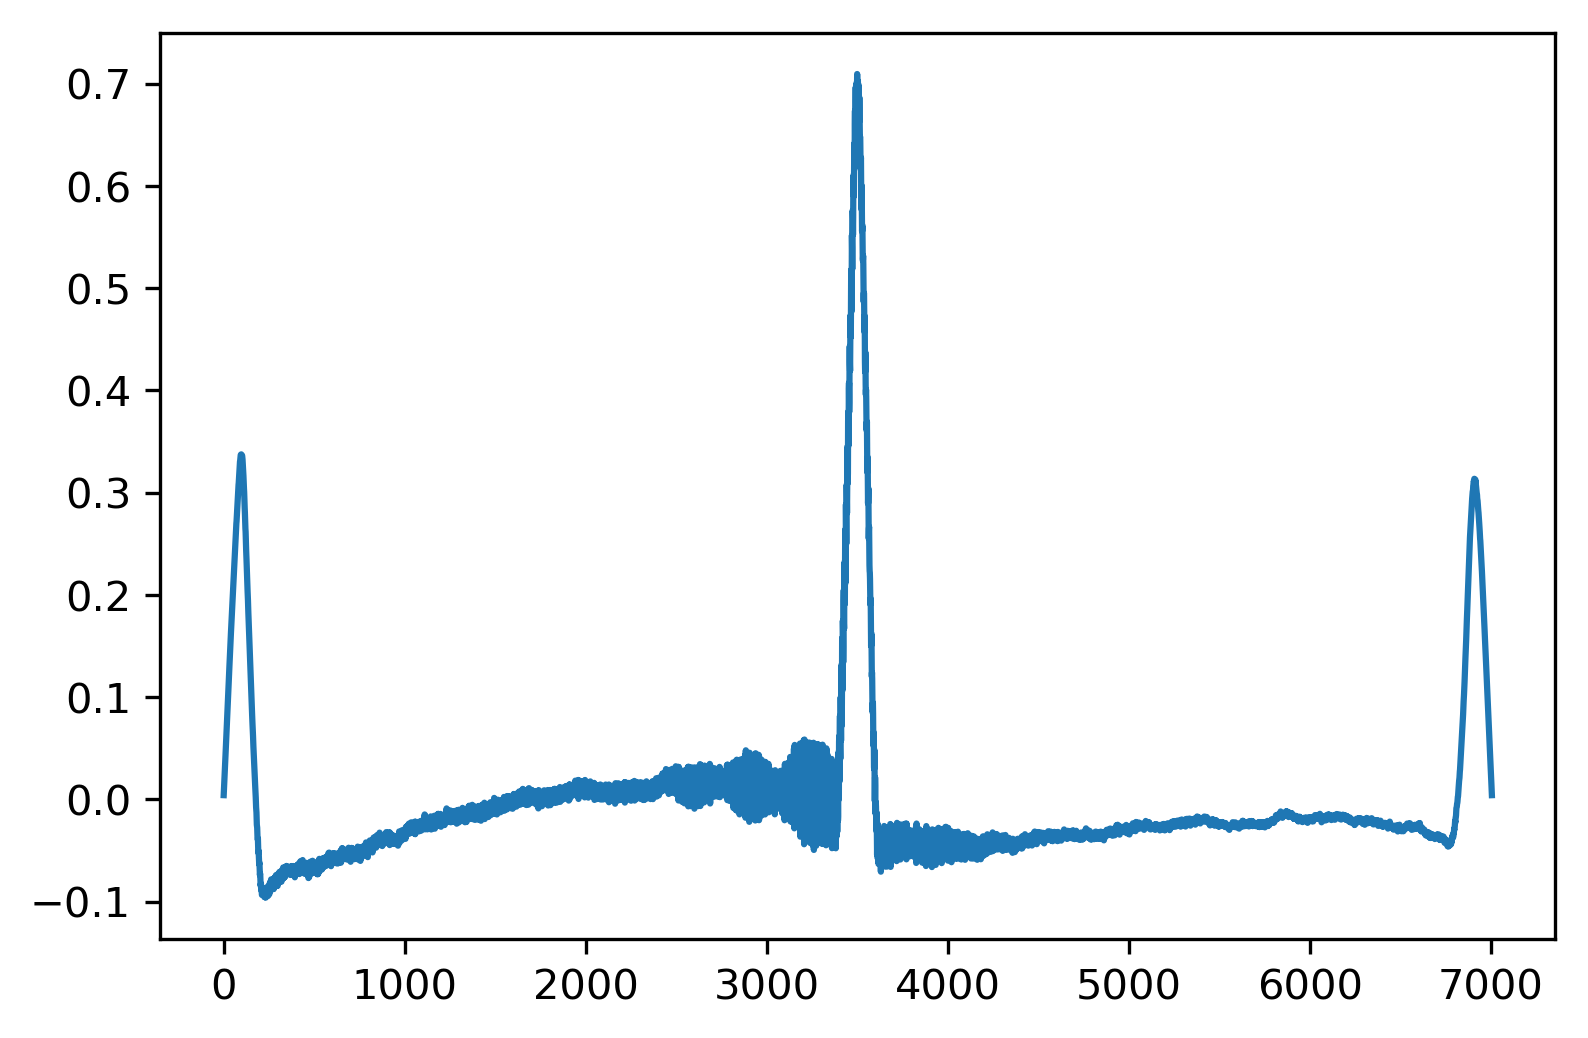

In [14]:
# Führt einen NCC-Vergleich der möglichen Verschiebungen zwischen den beiden Signalen durch
# und gibt die beste Verschiebung mit der höchsten Übereinstimmung zurück.
comparer = compare_normalized_cross_correlation.NormalizedCrossCorrelationComparer()
comparer.debug = True
comparer.mode = 'full'

if (len(df_subset_force_data) > len(df_subset_trace_data)):
    # Force Daten haben mehr Datenpunkte
    translation = comparer.getBestTranslation(
        df_subset_force_data[df_force_data_label],
        df_subset_trace_data[df_trace_data_label],
    )
    
    translation = len(df_subset_force_data) - translation

    if translation < 0:
        # Verschiebung nach links
        translation = abs(translation)
        df_subset_trace_data["time"] = df_subset_trace_data["time"] - df_subset_force_data.iloc[translation]["time"]
    else:
        # Verschiebung nach rechts
        df_subset_trace_data["time"] = df_subset_trace_data["time"] + df_subset_force_data.iloc[translation]["time"]
else:
    # Trace Daten haben mehr Datenpunkte
    translation = comparer.getBestTranslation(
        df_subset_trace_data[df_trace_data_label],
        df_subset_force_data[df_force_data_label],
    )

    translation = len(df_subset_force_data) - translation

    if translation < 0:
        # Verschiebung nach links
        translation = abs(translation)
        df_subset_trace_data["time"] = df_subset_trace_data["time"] - df_subset_force_data.iloc[translation]["time"]
    else:
        # Verschiebung nach rechts
        df_subset_trace_data["time"] = df_subset_trace_data["time"] + df_subset_force_data.iloc[translation]["time"]
        
result["correlation"] = comparer.ncorr[comparer.argmax]

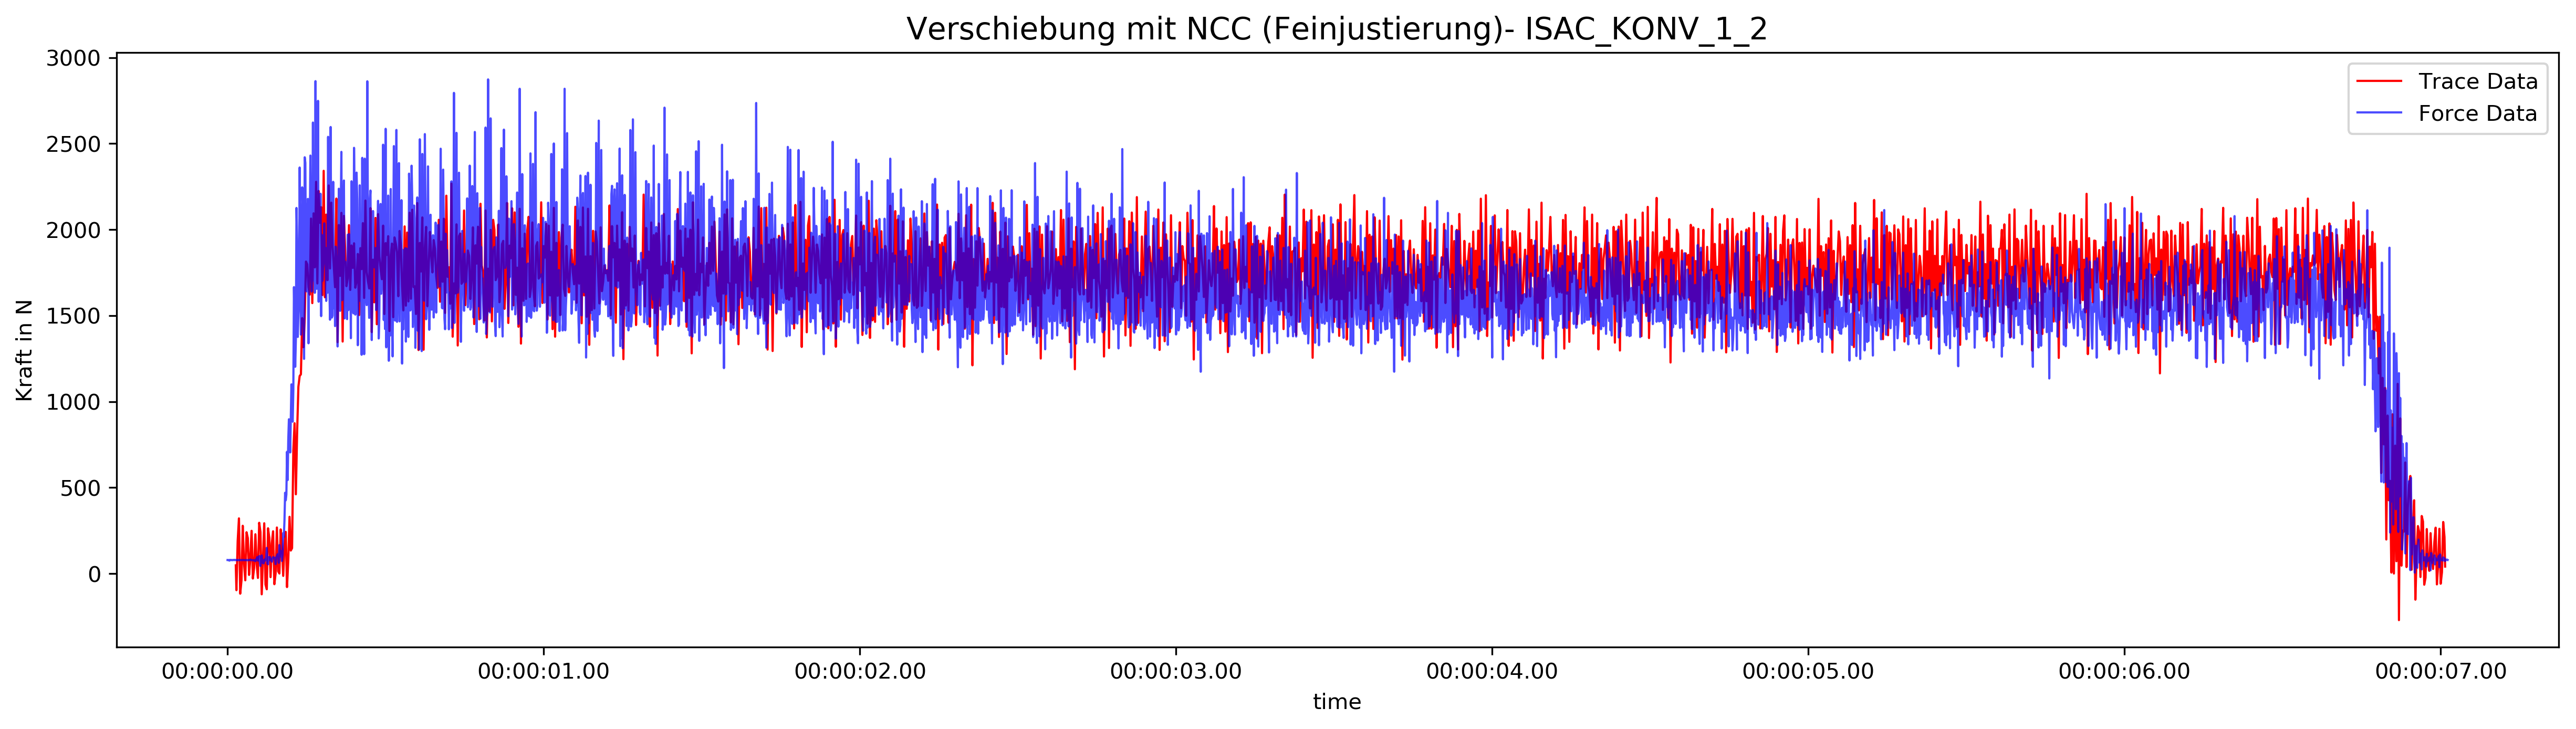

In [15]:
fig, axes = plt.subplots(figsize=(20,5))

df_subset_trace_data.plot(color='red', ax=axes, x='time', y=df_trace_data_label, linewidth=1.0, label="Trace Data")
df_subset_force_data.plot(color='blue', ax=axes, x='time', y=df_force_data_label, linewidth=1.0, label="Force Data", alpha=0.7)
axes.set_title("Verschiebung mit NCC (Feinjustierung)- " + cfg.project_database, fontdict = {'fontsize': 14})
axes.set_ylabel("Kraft in N");
axes.legend(loc='upper right')

plt.show()

In [16]:
print("Signal kürzen:")
print("len(df_subset_trace_data): " + str(len(df_subset_trace_data)))
print("len(df_subset_force_data): " + str(len(df_subset_force_data)))

df_subset_trace_data = df_subset_trace_data[(df_subset_trace_data["time"] >= df_subset_force_data["time"].iloc[0]) & (df_subset_trace_data["time"] <= df_subset_force_data["time"].iloc[-1])]
df_subset_force_data = df_subset_force_data[(df_subset_force_data["time"] >= df_subset_trace_data["time"].iloc[0]) & (df_subset_force_data["time"] <= df_subset_trace_data["time"].iloc[-1])]

print("")
print("Signallänge gekürzt:")
print("len(df_subset_trace_data): " + str(len(df_subset_trace_data)))
print("len(df_subset_force_data): " + str(len(df_subset_force_data)))

Signal kürzen:
len(df_subset_trace_data): 3495
len(df_subset_force_data): 3512

Signallänge gekürzt:
len(df_subset_trace_data): 3495
len(df_subset_force_data): 3495


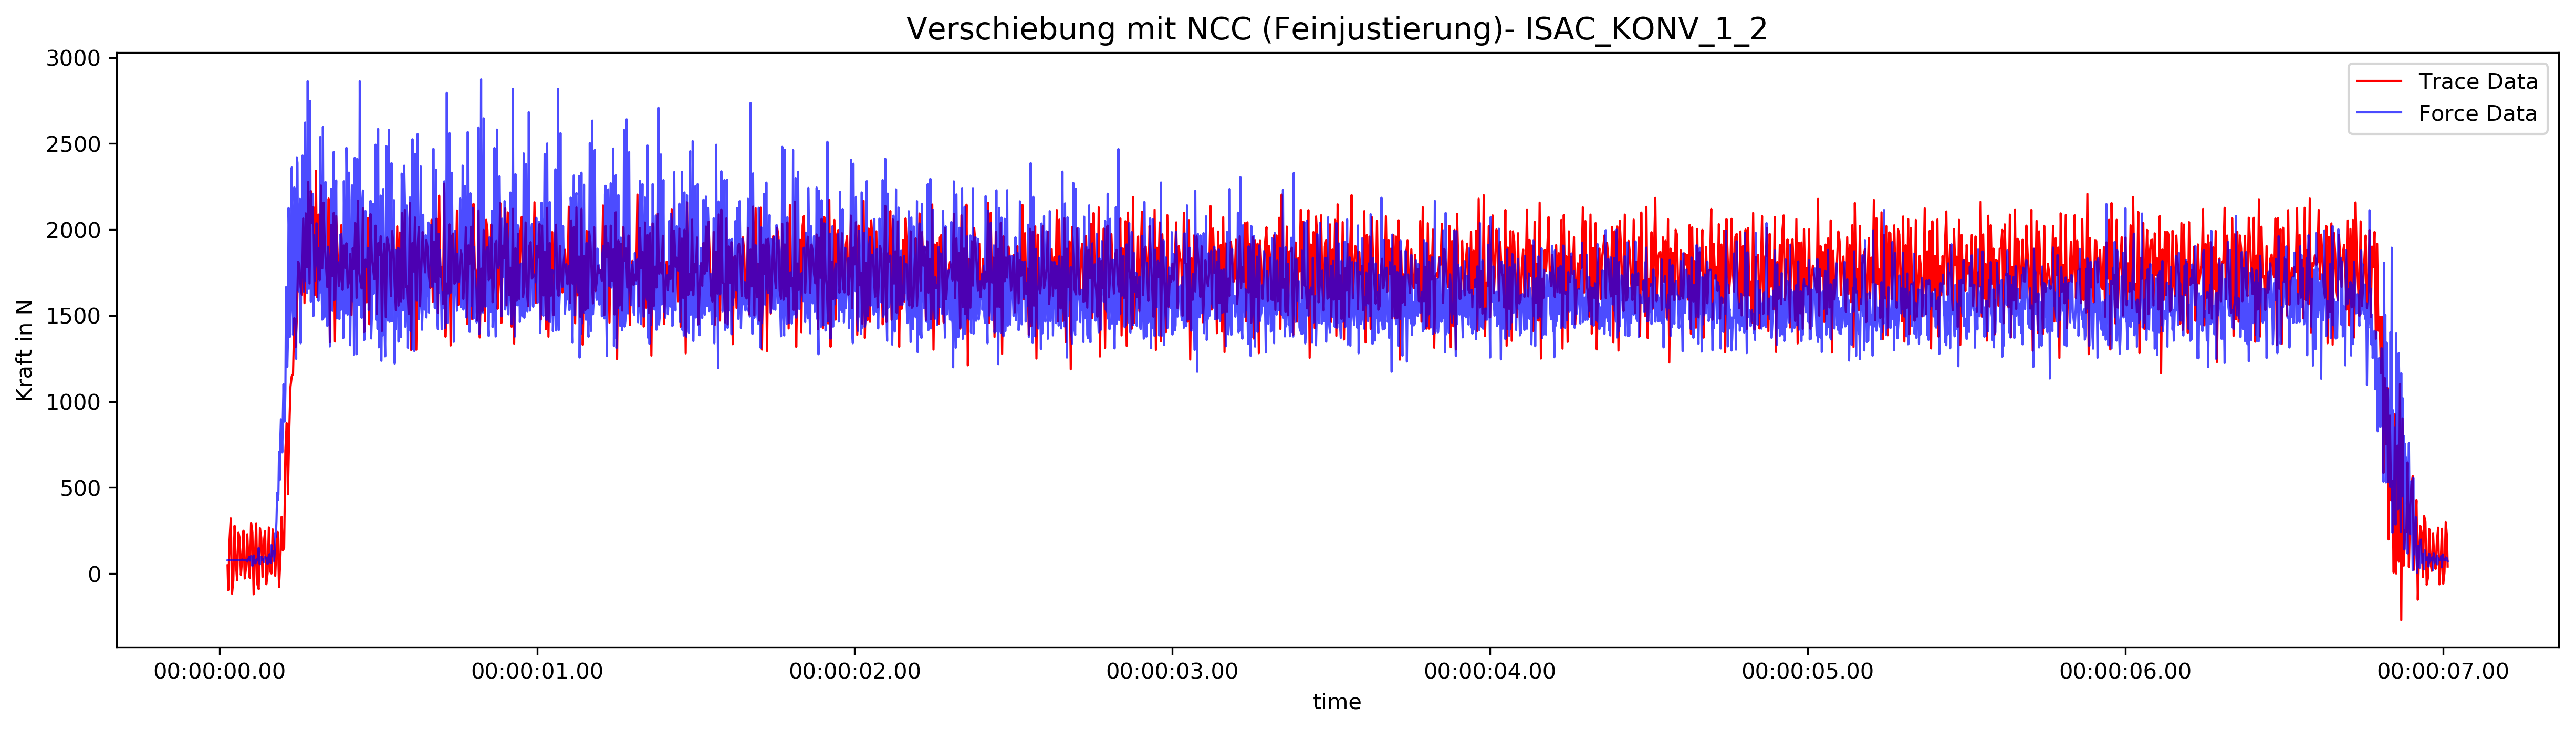

In [17]:
fig, axes = plt.subplots(figsize=(20,5))
    
df_subset_trace_data.plot(color='red', ax=axes, x='time', y=df_trace_data_label, linewidth=1.0, label="Trace Data")
df_subset_force_data.plot(color='blue', ax=axes, x='time', y=df_force_data_label, linewidth=1.0, label="Force Data", alpha=0.7)
axes.set_title("Verschiebung mit NCC (Feinjustierung)- " + cfg.project_database, fontdict = {'fontsize': 14})
axes.set_ylabel("Kraft in N");
axes.legend(loc='upper right')
    
plt.show()

#### Berechnung MSE danach

In [18]:
df_test = pd.merge(df_subset_force_data[["time", df_force_data_label]],
                   df_subset_trace_data[["time", df_trace_data_label]],
                    on="time",
                    how="inner")

mse_after = calculate_mean_squared_error(df_test[df_force_data_label],
                             df_test[df_trace_data_label])

result["mse_after"] = mse_after

#### Kennzahlen

In [19]:
print("MSE davor: " + str(round(mse_before, 2)))
print("MSE danach: " + str(round(mse_after, 2)))
print("")

calc_perc_diff_mse = round(100 - mse_after / (mse_before / 100), 2)
print("Verbesserung um " + str(calc_perc_diff_mse) + "%")

result["mse_improvement"] = calc_perc_diff_mse

MSE davor: 50489.1
MSE danach: 49788.73

Verbesserung um 1.39%


In [20]:
data = [
    result["name"], 
#    result["trace"]["datapoints"],
#    result["trace"]["duration"].iloc[0].seconds,
#    result["trace"]["duration_relevant_signal"].iloc[0].seconds,
#    result["force"]["datapoints"],
#    result["force"]["duration"].iloc[0].seconds,
    result["force"]["duration_relevant_signal"].iloc[0].seconds,
    result["mse_before"],
    result["mse_after"],
    result["mse_improvement"],
    result["correlation"]
]

columns = [
    "name",
#    "trace_datapoints",
#    "trace_duration",
#    "trace_duration_relevant_signal",
#    "force_datapoints",
#    "force_duration",
    "duration_relevant_signal [sec]",
    "mse_before_ncc",
    "mse_after_ncc",
    "mse_improvement",
    "correlation"
]

result["data"] = data
result["columns"] = columns

resultTable = pd.DataFrame([data], columns=columns)

resultTable = resultTable.reset_index(drop=True)
resultTable = resultTable.set_index("name")

resultTable.transpose()

name,ISAC_KONV_1_2
duration_relevant_signal [sec],7.000000
mse_before_ncc,50489.096827
mse_after_ncc,49788.726968
mse_improvement,1.390000
correlation,0.709513


#### Vergleich der einzelnen Versuche:

Wenn man das Notebook /notebooks/data_compare/Presentation_Test_Data.ipynb ausführt, erhält man am Ende einen Vergleich der einzelnen Versuche zueinander.

Das Ergebnis sieht dann circa so aus:

| name | duration_relevant_signal [sec] | mse_before_ncc | mse_after_ncc | mse_improvement | correlation |      |
|------|--------------------------------|----------------|---------------|-----------------|-------------|------|
| 0    | ISAC_HMILL_1_1                 | 85             | 12008         | 12008           | -0.03       | 0.34 |
| 1    | ISAC_HMILL_1_2                 | 85             | 11216         | 11216           | 0.00        | 0.33 |
| 2    | ISAC_HMILL_2_1                 | 85             | 11896         | 11896           | 0.00        | 0.34 |
| 3    | ISAC_HMILL_2_2                 | 85             | 11183         | 11183           | 0.45        | 0.34 |
| 4    | ISAC_HMILL_3_1                 | 85             | 11972         | 11972           | 0.00        | 0.34 |
| 5    | ISAC_HMILL_3_2                 | 85             | 11329         | 11329           | -0.04       | 0.34 |
| 6    | ISAC_KONV_1_1                  | 7              | 52117         | 52117           | -4.03       | 0.70 |
| 7    | ISAC_KONV_1_2                  | 7              | 50489         | 50489           | 1.39        | 0.71 |
| 8    | ISAC_KONV_2_2                  | 6              | 128433        | 128433          | 58.21       | 0.44 |
| 9    | ISAC_KONV_3_1                  | 6              | 175409        | 175409          | 23.67       | 0.24 |
| 10   | ISAC_SCAM_1_1                  | 289            | 46561         | 46561           | 0.07        | 0.19 |
| 11   | ISAC_SCAM_1_2                  | 289            | 45315         | 45315           | -0.04       | 0.21 |
| 12   | ISAC_SCAM_2_1                  | 289            | 47986         | 47986           | 0.30        | 0.19 |
| 13   | ISAC_SCAM_2_2                  | 290            | 44244         | 44244           | 0.23        | 0.21 |
| 14   | ISAC_SCAM_3_1                  | 289            | 47706         | 47706           | 0.24        | 0.20 |
| 15   | ISAC_SCAM_3_2                  | 289            | 45092         | 45092           | 0.20        | 0.22 |
| 16   | ISAC_SIM_1_1                   | 77             | 10307         | 10307           | 0.06        | 0.27 |
| 17   | ISAC_SIM_1_2                   | 77             | 10315         | 10315           | 0.35        | 0.27 |
| 18   | ISAC_SIM_2_1                   | 77             | 10214         | 10214           | 0.69        | 0.27 |
| 19   | ISAC_SIM_2_2                   | 77             | 10189         | 10189           | 0.61        | 0.27 |
| 20   | ISAC_SIM_3_1                   | 77             | 10832         | 10832           | 1.49        | 0.27 |
| 21   | ISAC_SIM_3_2                   | 77             | 10286         | 10286           | 0.20        | 0.27 |